In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/수리적빅데이터개론/OIBC

/content/drive/MyDrive/수리적빅데이터개론/OIBC


In [ ]:
API_KEY = "API_KEY"

In [3]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import math

In [4]:
gens = pd.read_csv('data/preprocessed/pp_gens.csv')
model0_1 = pd.read_csv('data/preprocessed/pp_model0_1.csv')
model1_1 = pd.read_csv('data/preprocessed/pp_model1_1.csv')
model2_1 = pd.read_csv('data/preprocessed/pp_model2_1.csv')
model3_1 = pd.read_csv('data/preprocessed/pp_model3_1.csv')
model4_1 = pd.read_csv('data/preprocessed/pp_model4_1.csv')
weather_forecast1 = pd.read_csv('data/preprocessed/pp_weather_forecast1.csv')

In [5]:
model0_2 = pd.read_csv('data/preprocessed/pp_model0_2.csv')
model1_2 = pd.read_csv('data/preprocessed/pp_model1_2.csv')
model2_2 = pd.read_csv('data/preprocessed/pp_model2_2.csv')
model3_2 = pd.read_csv('data/preprocessed/pp_model3_2.csv')
model4_2 = pd.read_csv('data/preprocessed/pp_model4_2.csv')
weather_forecast2 = pd.read_csv('data/preprocessed/pp_weather_forecast2.csv')

In [6]:
def time_converter(df):
    # 'time' 열에서 년도, 월, 일, 시간 추출하여 새로운 열로 저장
    #df['year'] = pd.to_datetime(df['time']).dt.year
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['day'] = pd.to_datetime(df['time']).dt.day
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    # 시간으로 sin,cos시간 만들어 새로운 열로 저장
    df['cos_time'] = np.cos(2*np.pi*(df.hour/24))
    df['sin_time'] = np.sin(2*np.pi*(df.hour/24))
    # 필요 없는 데이터 삭제
    df = df.drop('time', axis=1)
    return df

In [7]:
def calc_profit(actual_gens: list[int], forecast_gens: list[int]):
    CAPACITY = 99.0
    facility_utilization_rate = [actual / CAPACITY for actual in actual_gens]

    filter_facility_utilization_rate = [
        utilization >= 0.1 for utilization in facility_utilization_rate
    ]

    errors = [
        abs(forecast - actual) / CAPACITY * 100
        for forecast, actual in zip(forecast_gens, actual_gens)
    ]

    target_errors = [
        error
        for error, is_filtered in zip(errors, filter_facility_utilization_rate)
        if is_filtered
    ]
    target_actual_gens = [
        actual
        for actual, is_filtered in zip(
            actual_gens, filter_facility_utilization_rate
        )
        if is_filtered
    ]

    profits = [0] * len(target_actual_gens)

    for i, error in enumerate(target_errors):
        if error <= 6:
            profits[i] = target_actual_gens[i] * 4
        elif 6 < error <= 8:
            profits[i] = target_actual_gens[i] * 3

    return profits

In [8]:
model0_1 = model0_1.drop(['round', 'model_id'], axis=1)
model1_1 = model1_1.drop(['round', 'model_id'], axis=1)
model2_1 = model2_1.drop(['round', 'model_id'], axis=1)
model3_1 = model3_1.drop(['round', 'model_id'], axis=1)
model4_1 = model4_1.drop(['round', 'model_id'], axis=1)
weather_forecast1 = weather_forecast1.drop(['round', 'time'], axis=1)

In [9]:
model0_2 = model0_2.drop(['round', 'model_id'], axis=1)
model1_2 = model1_2.drop(['round', 'model_id'], axis=1)
model2_2 = model2_2.drop(['round', 'model_id'], axis=1)
model3_2 = model3_2.drop(['round', 'model_id'], axis=1)
model4_2 = model4_2.drop(['round', 'model_id'], axis=1)
weather_forecast2 = weather_forecast2.drop(['round', 'time'], axis=1)

In [10]:
gens = time_converter(gens)

In [11]:
weather_forecast1.head()

,cloud,temp,humidity,ground_press,wind_speed,wind_dir,rain,snow,dew_point,vis,uv_idx,azimuth,elevation
0,6.0,20.03,93.0,1009.0,3.01,162.0,0.0,0.0,18.3333,16.0934,0.0,6.70428,-31.5296
1,7.0,19.88,95.0,1009.0,3.16,159.0,0.0,0.0,18.3333,16.0934,0.0,22.19640,-28.4404
2,17.0,19.99,96.0,1008.0,2.92,161.0,0.0,0.0,18.3333,16.0934,0.0,35.91940,-22.4374
3,100.0,20.19,96.0,1008.0,2.79,157.0,0.0,0.0,17.7778,16.0934,0.0,47.55770,-14.2214
4,100.0,20.34,95.0,1008.0,2.74,156.0,0.0,0.0,18.3333,16.0934,0.0,57.37820,-4.4447


In [12]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [13]:
y = pd.DataFrame({'gens':gens['amount']})
X1 = gens.drop('amount', axis=1)
X1 = pd.concat([X1, weather_forecast1], axis=1)
X1['model1'] = model0_1['amount']
X1['model2'] = model1_1['amount']
X1['model3'] = model2_1['amount']
X1['model4'] = model3_1['amount']
X1['model5'] = model4_1['amount']

In [14]:
X2 = gens.drop('amount', axis=1)
X2 = pd.concat([X2, weather_forecast2], axis=1)
X2['model1'] = model0_2['amount']
X2['model2'] = model1_2['amount']
X2['model3'] = model2_2['amount']
X2['model4'] = model3_2['amount']
X2['model5'] = model4_2['amount']

In [15]:
print(X1.shape, X2.shape, y.shape)

(11568, 23) (11568, 23) (11568, 1)


In [16]:
X1

,month,day,hour,cos_time,sin_time,cloud,temp,humidity,ground_press,wind_speed,...,dew_point,vis,uv_idx,azimuth,elevation,model1,model2,model3,model4,model5
0,6,19,1,0.965926,0.258819,6.0,20.03,93.0,1009.0,3.01,...,18.3333,16.0934,0.0,6.70428,-31.5296,0.0,0.0,0.0,0.0,0.0
1,6,19,2,0.866025,0.500000,7.0,19.88,95.0,1009.0,3.16,...,18.3333,16.0934,0.0,22.19640,-28.4404,0.0,0.0,0.0,0.0,0.0
2,6,19,3,0.707107,0.707107,17.0,19.99,96.0,1008.0,2.92,...,18.3333,16.0934,0.0,35.91940,-22.4374,0.0,0.0,0.0,0.0,0.0
3,6,19,4,0.500000,0.866025,100.0,20.19,96.0,1008.0,2.79,...,17.7778,16.0934,0.0,47.55770,-14.2214,0.0,0.0,0.0,0.0,0.0
4,6,19,5,0.258819,0.965926,100.0,20.34,95.0,1008.0,2.74,...,18.3333,16.0934,0.0,57.37820,-4.4447,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,10,15,20,0.500000,-0.866025,0.0,18.50,72.0,1015.0,5.49,...,12.7778,16.0934,0.0,277.46500,-25.3792,0.0,0.0,0.0,0.0,0.0
11564,10,15,21,0.707107,-0.707107,0.0,18.60,73.0,1015.0,5.36,...,12.7778,16.0934,0.0,287.67900,-37.4097,0.0,0.0,0.0,0.0,0.0
11565,10,15,22,0.866025,-0.500000,0.0,18.64,73.0,1015.0,5.77,...,12.7778,16.0934,0.0,301.00700,-48.6552,0.0,0.0,0.0,0.0,0.0
11566,10,15,23,0.965926,-0.258819,0.0,18.70,70.0,1015.0,5.91,...,12.2222,16.0934,0.0,320.43400,-58.0565,0.0,0.0,0.0,0.0,0.0


In [17]:
X1_temp = X1.drop(['vis', 'humidity', 'azimuth', 'elevation', 'dew_point', 'model5', 'model4'], axis=1)

In [18]:
X1_temp

,month,day,hour,cos_time,sin_time,cloud,temp,ground_press,wind_speed,wind_dir,rain,snow,uv_idx,model1,model2,model3
0,6,19,1,0.965926,0.258819,6.0,20.03,1009.0,3.01,162.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,19,2,0.866025,0.500000,7.0,19.88,1009.0,3.16,159.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,19,3,0.707107,0.707107,17.0,19.99,1008.0,2.92,161.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,19,4,0.500000,0.866025,100.0,20.19,1008.0,2.79,157.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,19,5,0.258819,0.965926,100.0,20.34,1008.0,2.74,156.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,10,15,20,0.500000,-0.866025,0.0,18.50,1015.0,5.49,325.0,0.0,0.0,0.0,0.0,0.0,0.0
11564,10,15,21,0.707107,-0.707107,0.0,18.60,1015.0,5.36,313.0,0.0,0.0,0.0,0.0,0.0,0.0
11565,10,15,22,0.866025,-0.500000,0.0,18.64,1015.0,5.77,306.0,0.0,0.0,0.0,0.0,0.0,0.0
11566,10,15,23,0.965926,-0.258819,0.0,18.70,1015.0,5.91,302.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
seed = 42
# 데이터 분할
X1_train, X1_test, y_train, y_test = train_test_split(X1_temp, y, test_size=0.2, random_state=seed)

In [20]:
model1 = XGBRegressor(
    objective='reg:squarederror',  # 회귀 문제의 경우 목표 변수로 'reg:squarederror'를 설정
    n_estimators=8000,  # 트리의 개수
    learning_rate=0.01,  # 학습률
    max_depth=6,  # 트리의 최대 깊이
    colsample_bytree=0.8,  # 각 트리에서 사용할 특성의 비율
    subsample=1.0,  # 각 트리에서 사용할 학습 데이터의 비율
    alpha=24,
    scale_pos_weight=24,
    random_state=seed  # 랜덤 시드 설정
)

# 모델 학습
model1.fit(X1_train, y_train)

# 테스트 데이터로 예측
y1_pred = model1.predict(X1_test)

In [21]:
X2_temp = X2.drop(['vis', 'humidity', 'azimuth', 'elevation', 'dew_point', 'model5', 'model4'], axis=1)
X2_temp

,month,day,hour,cos_time,sin_time,cloud,temp,ground_press,wind_speed,wind_dir,rain,snow,uv_idx,model1,model2,model3
0,6,19,1,0.965926,0.258819,7.0,19.95,1009.0,2.65,152.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,19,2,0.866025,0.500000,24.0,20.15,1009.0,2.55,148.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,19,3,0.707107,0.707107,36.0,20.23,1009.0,2.60,158.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,19,4,0.500000,0.866025,95.0,20.35,1008.0,2.84,164.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,19,5,0.258819,0.965926,97.0,20.43,1009.0,3.06,163.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,10,15,20,0.500000,-0.866025,0.0,18.51,1015.0,5.56,328.0,0.0,0.0,0.0,0.0,0.0,0.0
11564,10,15,21,0.707107,-0.707107,0.0,18.59,1015.0,5.25,317.0,0.0,0.0,0.0,0.0,0.0,0.0
11565,10,15,22,0.866025,-0.500000,0.0,18.68,1015.0,5.58,310.0,0.0,0.0,0.0,0.0,0.0,0.0
11566,10,15,23,0.965926,-0.258819,0.0,18.77,1015.0,5.75,306.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
X2_temp.shape

(11568, 16)

In [23]:
seed = 42
# 데이터 분할
X2_train, X2_test, y_train, y_test = train_test_split(X2_temp, y, test_size=0.2, random_state=seed)

In [24]:
model2 = XGBRegressor(
    objective='reg:squarederror',  # 회귀 문제의 경우 목표 변수로 'reg:squarederror'를 설정
    n_estimators=7000,  # 트리의 개수
    learning_rate=0.01,  # 학습률
    max_depth=6,  # 트리의 최대 깊이
    colsample_bytree=1.0,  # 각 트리에서 사용할 특성의 비율
    subsample=1.0,  # 각 트리에서 사용할 학습 데이터의 비율
    alpha=24,
    scale_pos_weight=18,
    random_state=seed  # 랜덤 시드 설정
)

# 모델 학습
model2.fit(X2_train, y_train)

# 테스트 데이터로 예측
y2_pred = model2.predict(X2_test)

In [41]:
w = 1.03

In [26]:
incentive = sum(calc_profit(y_test['gens'], y_test['gens']))
print(incentive)

151230.82240000003


In [42]:
# 테스트 데이터로 예측
y2_pred = model1.predict(X2_test)

In [43]:
incentive1 = sum(calc_profit(y_test['gens'], y1_pred*w))
incentive2 = sum(calc_profit(y_test['gens'], y2_pred*w))
print("round1: ", incentive1)
print("round2: ", incentive2)

round1:  89221.025
round2:  84808.46860000002


In [38]:
from sklearn.metrics import mean_squared_error
# 모델 평가 (MSE 예시)
mse1 = mean_squared_error(y_test, y1_pred*w)
mse2 = mean_squared_error(y_test, y2_pred*w)
print("Mean Squared Error1:", mse1)
print("Mean Squared Error2:", mse2)

Mean Squared Error1: 56.47731205522556
Mean Squared Error2: 65.4307273693951


In [ ]:
# 10-27
day27 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 9, 36, 46, 53, 74, 89, 81, 64, 54, 23, 4,
0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day28 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
5, 29, 56, 67, 82,
78, 72, 63, 46, 17,
3, 0.0, 0.0, 0.0, 0.0, 0.0]
day29=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
4, 20, 56, 66, 76,
53, 57, 66, 42, 20,
2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day30=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
6, 22, 57, 68, 77,
81, 74, 61, 44, 20,
2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day31=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
4, 10, 22, 42, 77,
71, 73, 59, 41, 22,
2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day1=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
6, 30, 51, 58, 68,
68, 69, 55, 38, 18,
1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day2=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
6, 34, 47, 72, 77,
78, 73, 62, 44, 20,
2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day3=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
6, 24, 39, 47, 71,
61, 68, 36, 35, 8,
1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day4=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
6, 20, 42, 51, 36,
37, 34, 28, 8, 4,
2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
day5=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
2, 14, 18, 16, 18,
9, 7, 4, 6, 4,
2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
# 함수 만들기
import json
import requests
from datetime import datetime
import pytz
import numpy as np

# 한국 시간으로 바꾸기
def ConverKTime(fcst):
    for item in fcst:
        # 시간 문자열을 datetime 객체로 변환
        utc_time = datetime.strptime(item['time'], "%Y-%m-%dT%H:%M:%S%z")

        # UTC 시간대를 한국 시간대로 변환
        korea_time = utc_time.astimezone(pytz.timezone('Asia/Seoul'))

        # 시간 객체를 다시 문자열로 변환
        item['time'] = korea_time.strftime("%Y-%m-%dT%H:%M:%S%z")

    return fcst

# day, round 넣으면 해당 예측 값 리턴하기
def PredictionDayRound(date, round):
    gen_fcst = requests.get(f'https://research-api.solarkim.com/cmpt-2023/gen-forecasts/{date}/{round}', headers={
                            'Authorization': f'Bearer {API_KEY}'
                        }).json()

    weather_fcst = requests.get(f'https://research-api.solarkim.com/cmpt-2023/weathers-forecasts/{date}/{round}', headers={
                            'Authorization': f'Bearer {API_KEY}'
                        }).json()
    ConverKTime(gen_fcst)
    ConverKTime(weather_fcst)

    gen_fcst = pd.DataFrame(gen_fcst)
    weather_fcst = pd.DataFrame(weather_fcst)

    print(gen_fcst)
    print(weather_fcst)

    timeZone = pd.DataFrame(gen_fcst['time'])
    X1 = time_converter(timeZone)
    gen_fcst = gen_fcst.drop('time', axis=1)
    weather_fcst = weather_fcst.drop('time', axis=1)
    #print(gen_fcst.shape, weather_fcst.shape)

    X1 = pd.concat([X1, weather_fcst, gen_fcst], axis=1)
    X1 = X1.drop(['vis', 'humidity', 'azimuth', 'elevation', 'dew_point', 'model5', 'model4'], axis=1)


    return X1

In [ ]:
w1 = 1.03
w2 = 1.03
date = ["2023-11-17"]

In [ ]:
round1_X = PredictionDayRound(date[0], "1")
round2_X = PredictionDayRound(date[0], "2")

pred1 = model1.predict(round1_X) * w1
pred2 = model2.predict(round2_X) * w2



NameError: ignored

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame()
df['actual'] = y_test
df['pred1'] = pred1
df['pred2'] = pred2

# 그래프 크기 조절
plt.figure(figsize=(20, 10))  # (가로 크기, 세로 크기)를 지정합니다.

sns.lineplot(data=df['actual'], label='actual', linewidth=5)
sns.lineplot(data=df['pred1'], label='pred1')
sns.lineplot(data=df['pred2'], label='pred2')
plt.show()

NameError: ignored

In [ ]:
print(pred2)

In [ ]:
for i in range(24):
    if pred2[i] < 1:
        pred2[i] = 0
print(pred2)

In [ ]:
df = pd.DataFrame()
df['actual'] = y_test
df['pred'] = y1_pred

# 그래프 크기 조절
plt.figure(figsize=(20, 10))  # (가로 크기, 세로 크기)를 지정합니다.

sns.lineplot(data=df['actual'], label='actual', linewidth=5)
sns.lineplot(data=df['pred'], label='pred')
plt.show()

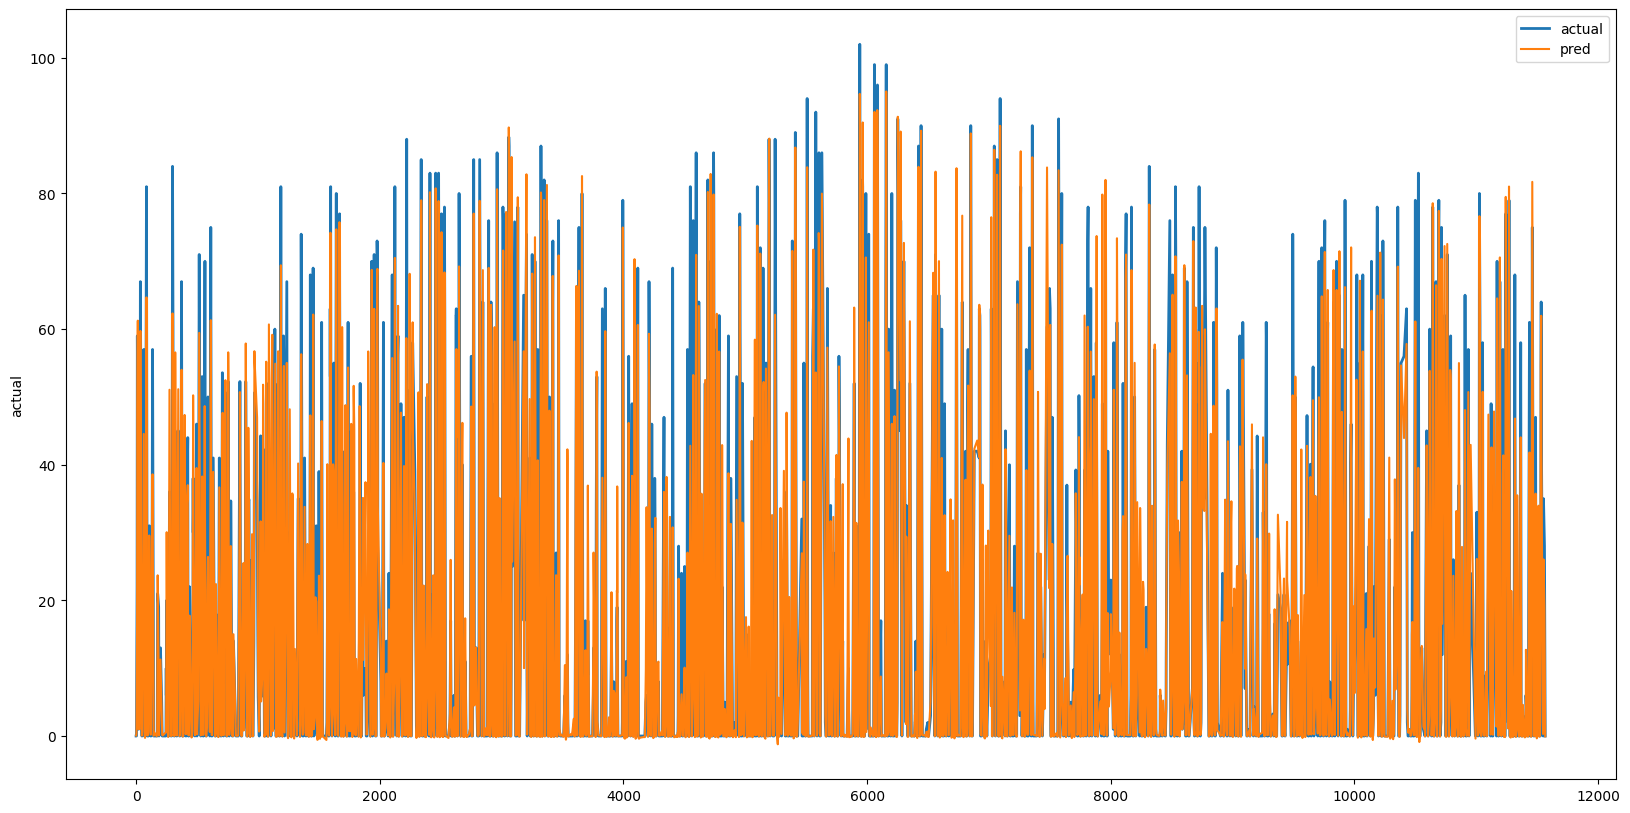

In [48]:
df = pd.DataFrame()
df['actual'] = y_test
df['pred'] = y2_pred

# 그래프 크기 조절
plt.figure(figsize=(20, 10))  # (가로 크기, 세로 크기)를 지정합니다.

sns.lineplot(data=df['actual'], label='actual', linewidth=2)
sns.lineplot(data=df['pred'], label='pred')
plt.show()